# Introduction

In this tutorial, you'll learn about two common manipulations for geospatial data: geocoding and table joins.

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import folium
from folium import Marker
import warnings 
warnings.filterwarnings('ignore')

# Geocoding

Geocoding is the process of converting the name of a place or an address to a location on a map. If you have ever looked up a geographic location based on a landmark description with Google Maps, Bing Maps, or Baidu Maps, for instance, then you have used a geocoder!
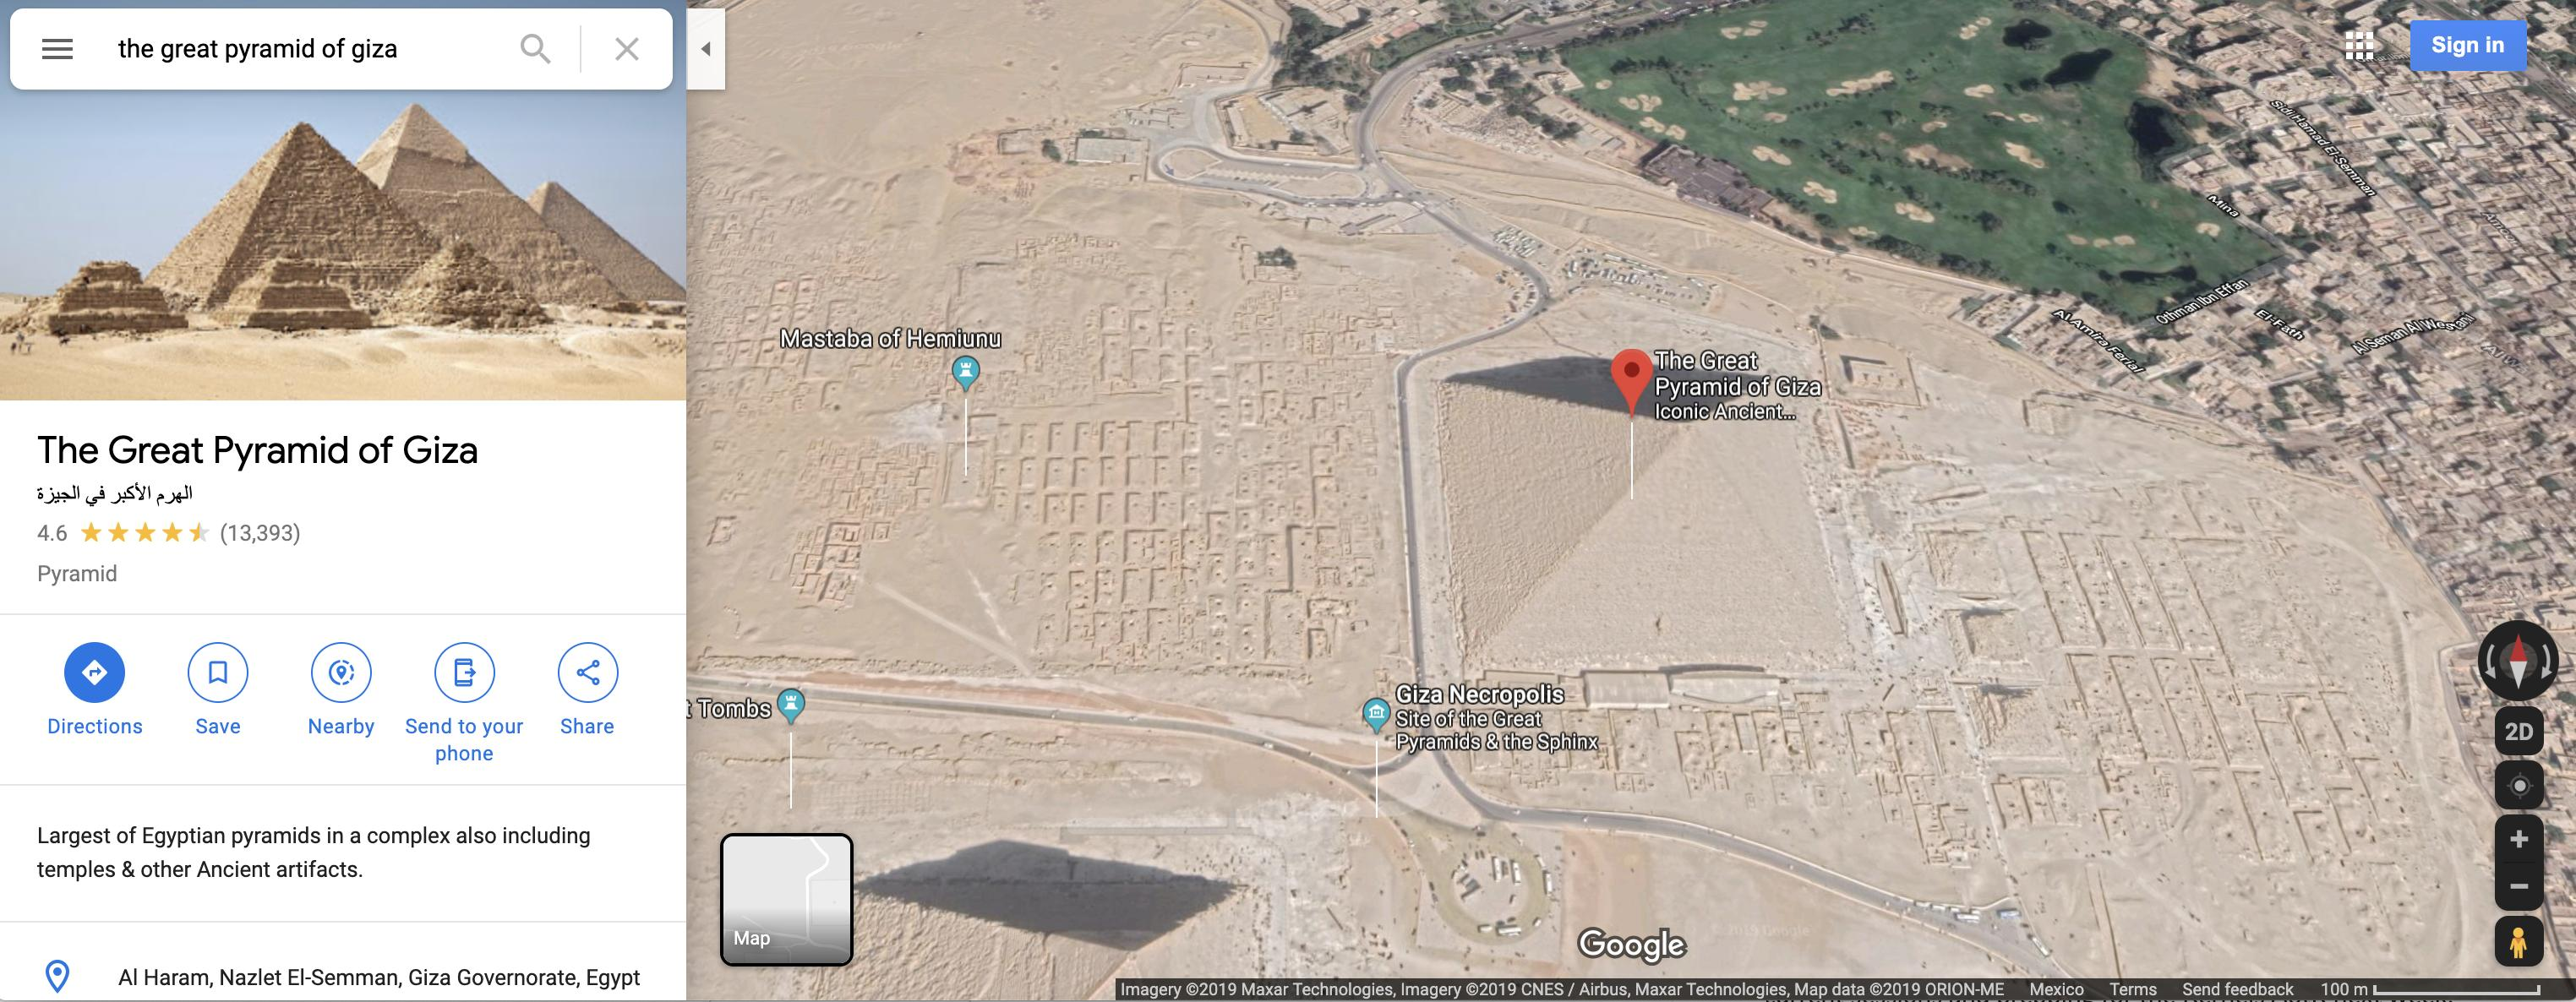
We'll use geopy to do all of our geocoding.

In [2]:
from geopy.geocoders import Nominatim

In the code cell above, Nominatim refers to the geocoding software that will be used to generate locations.

We begin by instantiating the geocoder. Then, we need only apply the name or address as a Python string. (In this case, we supply "Pyramid of Khufu", also known as the Great Pyramid of Giza.)

If the geocoding is successful, it returns a geopy.location.Location object with two important attributes:

- the "point" attribute contains the (latitude, longitude) location, and
- the "address" attribute contains the full address.

In [3]:
geolocator = Nominatim(user_agent="kaggle_learn")
location = geolocator.geocode("Pyramid of Khufu")

print(location.point)
print(location.address)

29 58m 44.976s N, 31 8m 3.17625s E
هرم خوفو, شارع ابو الهول السياحي, كوم الأخضر, الجيزة, 12125, مصر


The value for the "point" attribute is a geopy.point.Point object, and we can get the latitude and longitude from the latitude and longitude attributes, respectively.

In [4]:
point = location.point
print("Latitude:", point.latitude)
print("Longitude:", point.longitude)

Latitude: 29.97916
Longitude: 31.134215625236113


It's often the case that we'll need to geocode many different addresses. For instance, say we want to obtain the locations of 100 top universities in Europe.

In [5]:
universities = pd.read_csv("dataset/top_universities.csv")
universities.head()

Name
0     University of Oxford
1  University of Cambridge
2  Imperial College London
3               ETH Zurich
4                      UCL

Then we can use a lambda function to apply the geocoder to every row in the DataFrame. (We use a try/except statement to account for the case that the geocoding is unsuccessful.)

In [6]:
def my_geocoder(row):
    try:
        point = geolocator.geocode(row).point
        return pd.Series({'Latitude': point.latitude, 'Longitude': point.longitude})
    except:
        return None

universities[['Latitude', 'Longitude']] = universities.apply(lambda x: my_geocoder(x['Name']), axis=1)

print("{}% of addresses were geocoded!".format(
    (1 - sum(np.isnan(universities["Latitude"])) / len(universities)) * 100))

# Drop universities that were not successfully geocoded
universities = universities.loc[~np.isnan(universities["Latitude"])]
universities = gpd.GeoDataFrame(
    universities, geometry=gpd.points_from_xy(universities.Longitude, universities.Latitude))
universities.crs = {'init': 'epsg:4326'}
universities.head()

95.0% of addresses were geocoded!


Name   Latitude   Longitude                     geometry
0     University of Oxford  33.650290 -117.828179  POINT (-117.82818 33.65029)
1  University of Cambridge  52.210946    0.092005     POINT (0.09200 52.21095)
2  Imperial College London  51.498959   -0.175641    POINT (-0.17564 51.49896)
3               ETH Zurich  47.376426    8.547671     POINT (8.54767 47.37643)
4                      UCL  51.521785   -0.135151    POINT (-0.13515 51.52179)

Next, we visualize all of the locations that were returned by the geocoder. Notice that a few of the locations are certainly inaccurate, as they're not in Europe!

In [7]:
# Create a map
m = folium.Map(location=[54, 15], tiles='openstreetmap', zoom_start=2)

# Add points to the map
for idx, row in universities.iterrows():
    Marker([row['Latitude'], row['Longitude']], popup=row['Name']).add_to(m)

# Display the map
m

# Table joins

Now, we'll switch topics and think about how to combine data from different sources.

## Attribute join

You already know how to use pd.DataFrame.join() to combine information from multiple DataFrames with a shared index. We refer to this way of joining data (by simpling matching values in the index) as an **attribute join.**

When performing an attribute join with a GeoDataFrame, it's best to use the gpd.GeoDataFrame.merge(). To illustrate this, we'll work with a GeoDataFrame europe_boundaries containing the boundaries for every country in Europe. The first five rows of this GeoDataFrame are printed below.

In [8]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
europe = world.loc[world.continent == 'Europe'].reset_index(drop=True)

europe_stats = europe[["name", "pop_est", "gdp_md_est"]]
europe_boundaries = europe[["name", "geometry"]]

In [9]:
europe_boundaries.head()

name                                           geometry
0   Russia  MULTIPOLYGON (((180.00000 71.51571, 180.00000 ...
1   Norway  MULTIPOLYGON (((15.14282 79.67431, 15.52255 80...
2   France  MULTIPOLYGON (((-51.65780 4.15623, -52.24934 3...
3   Sweden  POLYGON ((11.02737 58.85615, 11.46827 59.43239...
4  Belarus  POLYGON ((28.17671 56.16913, 29.22951 55.91834...

We'll join it with a DataFrame europe_stats containing the estimated population and gross domestic product (GDP) for each country.

In [10]:
europe_stats.head()

name      pop_est  gdp_md_est
0   Russia  144373535.0     1699876
1   Norway    5347896.0      403336
2   France   67059887.0     2715518
3   Sweden   10285453.0      530883
4  Belarus    9466856.0       63080

We do the attribute join in the code cell below. The on argument is set to the column name that is used to match rows in europe_boundaries to rows in europe_stats.

In [11]:
# Use an attribute join to merge data about countries in Europe
europe = europe_boundaries.merge(europe_stats, on="name")
europe.head()

name                                           geometry      pop_est  \
0   Russia  MULTIPOLYGON (((180.00000 71.51571, 180.00000 ...  144373535.0   
1   Norway  MULTIPOLYGON (((15.14282 79.67431, 15.52255 80...    5347896.0   
2   France  MULTIPOLYGON (((-51.65780 4.15623, -52.24934 3...   67059887.0   
3   Sweden  POLYGON ((11.02737 58.85615, 11.46827 59.43239...   10285453.0   
4  Belarus  POLYGON ((28.17671 56.16913, 29.22951 55.91834...    9466856.0   

   gdp_md_est  
0     1699876  
1      403336  
2     2715518  
3      530883  
4       63080

## Spatial join
Another type of join is a spatial join. With a spatial join, we combine GeoDataFrames based on the spatial relationship between the objects in the "geometry" columns. For instance, we already have a GeoDataFrame universities containing geocoded addresses of European universities.

Then we can use a spatial join to match each university to its corresponding country. We do this with gpd.sjoin().

In [12]:
# Use spatial join to match universities to countries in Europe
european_universities = gpd.sjoin(universities, europe)

# Investigate the result
print("We located {} universities.".format(len(universities)))
print("Only {} of the universities were located in Europe (in {} different countries).".format(
    len(european_universities), len(european_universities.name.unique())))

european_universities.head()

We located 95 universities.
Only 90 of the universities were located in Europe (in 15 different countries).


Name   Latitude  Longitude  \
1                           University of Cambridge  52.210946   0.092005   
2                           Imperial College London  51.498959  -0.175641   
4                                               UCL  51.521785  -0.135151   
5  London School of Economics and Political Science  51.514261  -0.116734   
6                           University of Edinburgh  55.944076  -3.188374   

                    geometry  index_right            name     pop_est  \
1   POINT (0.09200 52.21095)           28  United Kingdom  66834405.0   
2  POINT (-0.17564 51.49896)           28  United Kingdom  66834405.0   
4  POINT (-0.13515 51.52179)           28  United Kingdom  66834405.0   
5  POINT (-0.11673 51.51426)           28  United Kingdom  66834405.0   
6  POINT (-3.18837 55.94408)           28  United Kingdom  66834405.0   

   gdp_md_est  
1     2829108  
2     2829108  
4     2829108  
5     2829108  
6     2829108

The spatial join above looks at the "geometry" columns in both GeoDataFrames. If a Point object from the universities GeoDataFrame intersects a Polygon object from the europe DataFrame, the corresponding rows are combined and added as a single row of the european_universities DataFrame. Otherwise, countries without a matching university (and universities without a matching country) are omitted from the results.

The gpd.sjoin() method is customizable for different types of joins, through the how and op arguments. For instance, you can do the equivalent of a SQL left (or right) join by setting how='left' (or how='right'). We won't go into the details in this course, but you can learn more in the documentation.

# Your turn

# Introduction

You are a Starbucks big data analyst ([that’s a real job!](https://www.forbes.com/sites/bernardmarr/2018/05/28/starbucks-using-big-data-analytics-and-artificial-intelligence-to-boost-performance/#130c7d765cdc)) looking to find the next store into a [Starbucks Reserve Roastery](https://www.businessinsider.com/starbucks-reserve-roastery-compared-regular-starbucks-2018-12#also-on-the-first-floor-was-the-main-coffee-bar-five-hourglass-like-units-hold-the-freshly-roasted-coffee-beans-that-are-used-in-each-order-the-selection-rotates-seasonally-5).  These roasteries are much larger than a typical Starbucks store and have several additional features, including various food and wine options, along with upscale lounge areas.  You'll investigate the demographics of various counties in the state of California, to determine potentially suitable locations.

<center>
<img src="https://i.imgur.com/BIyE6kR.png" width="450"><br/><br/>
</center>

Before you get started, run the code cell below to set everything up.

In [13]:
import math
import pandas as pd
import geopandas as gpd
import folium 
from folium import Marker
from folium.plugins import MarkerCluster

You'll use the `embed_map()` function from the previous exercise to visualize your maps.

In [14]:
def embed_map(m, file_name):
    from IPython.display import IFrame
    m.save(file_name)
    return IFrame(file_name, width='100%', height='500px')

# Exercises

### 1. Geocode the missing locations.

Run the next code cell to create a DataFrame `starbucks` containing Starbucks locations in the state of California.

In [15]:
# Load and preview Starbucks locations in California
starbucks = pd.read_csv("dataset/starbucks_locations.csv")
starbucks.head()

Store Number               Store Name  \
0  10429-100710       Palmdale & Hwy 395   
1       635-352    Kanan & Thousand Oaks   
2   74510-27669  Vons-Agoura Hills #2001   
3  29839-255026    Target Anaheim T-0677   
4  23463-230284   Safeway - Alameda 3281   

                                   Address          City  Longitude  Latitude  
0             14136 US Hwy 395 Adelanto CA      Adelanto    -117.40     34.51  
1                5827 Kanan Road Agoura CA        Agoura    -118.76     34.16  
2           5671 Kanan Rd. Agoura Hills CA  Agoura Hills    -118.76     34.15  
3  8148 E SANTA ANA CANYON ROAD AHAHEIM CA       AHAHEIM    -117.75     33.87  
4               2600 5th Street Alameda CA       Alameda    -122.28     37.79

Most of the stores have known (latitude, longitude) locations.  But, all of the locations in the city of Berkeley are missing.

In [16]:
# How many rows in each column have missing values?
print(starbucks.isnull().sum())

# View rows with missing locations
rows_with_missing = starbucks[starbucks["City"]=="Berkeley"]
rows_with_missing

Store Number    0
Store Name      0
Address         0
City            0
Longitude       5
Latitude        5
dtype: int64


Store Number                Store Name  \
153      5406-945  2224 Shattuck - Berkeley   
154       570-512                Solano Ave   
155  17877-164526   Safeway - Berkeley #691   
156  19864-202264         Telegraph & Ashby   
157     9217-9253           2128 Oxford St.   

                               Address      City  Longitude  Latitude  
153   2224 Shattuck Avenue Berkeley CA  Berkeley        NaN       NaN  
154     1799 Solano Avenue Berkeley CA  Berkeley        NaN       NaN  
155    1444 Shattuck Place Berkeley CA  Berkeley        NaN       NaN  
156  3001 Telegraph Avenue Berkeley CA  Berkeley        NaN       NaN  
157     2128 Oxford Street Berkeley CA  Berkeley        NaN       NaN

Use the code cell below to fill in these values with the OpenStreetMap Nominatim geocoder.

Note that in the tutorial, we used `geocode()` (from `geopandas.tools`) to geocode values, and this is what you can use in your own projects outside of this micro-course.  

In this exercise, you will use a slightly different function `geocode()` (from `learntools.geospatial.tools`).  This function was imported at the top of the notebook and works identically to the function from GeoPandas.

So, in other words, as long as: 
- you don't change the import statements at the top of the notebook, and 
- you call the geocoding function as `geocode()` in the code cell below, 

your code will work as intended!

In [20]:
# Create the geocoder
geolocator = Nominatim(user_agent="kaggle_learn")

# Your code here
def my_geocoder(row):
    point = geolocator.geocode(row).point
    return pd.Series({'Latitude': point.latitude, 'Longitude': point.longitude})

berkeley_locations = rows_with_missing.apply(lambda x: my_geocoder(x['Address']), axis=1)
starbucks.update(berkeley_locations)

### 2. View Berkeley locations.

Let's take a look at the locations you just found.  Visualize the (latitude, longitude) locations in Berkeley in the OpenStreetMap style. 

In [21]:
# Create a base map
m_2 = folium.Map(location=[37.88,-122.26], zoom_start=13)

# Your code here: Add a marker for each Berkeley location
berkeley_locations = starbucks[starbucks["City"]=="Berkeley"]
for idx, row in berkeley_locations.iterrows():
    Marker([row['Latitude'], row['Longitude']], popup=row['Store Name']).add_to(m_2)

# Show the map
embed_map(m_2, 'q_2.html')

Considering only the five locations in Berkeley, how many of the (latitude, longitude) locations seem potentially correct (are located in the correct city)?

*All five locations appear to be correct!*

### 3. Consolidate your data.

Run the code below to load a GeoDataFrame `CA_counties` containing the name, area (in square kilometers), and a unique id (in the "GEOID" column) for each county in the state of California.  The "geometry" column contains a polygon with county boundaries.

In [22]:
CA_counties = gpd.read_file("dataset/CA_county_boundaries/CA_county_boundaries/CA_county_boundaries.shp")
CA_counties.head()

GEOID                  name    area_sqkm  \
0   6091         Sierra County  2491.995494   
1   6067     Sacramento County  2575.258262   
2   6083  Santa Barbara County  9813.817958   
3   6009      Calaveras County  2685.626726   
4   6111        Ventura County  5719.321379   

                                            geometry  
0  POLYGON ((-120.65560 39.69357, -120.65554 39.6...  
1  POLYGON ((-121.18858 38.71431, -121.18732 38.7...  
2  MULTIPOLYGON (((-120.58191 34.09856, -120.5822...  
3  POLYGON ((-120.63095 38.34111, -120.63058 38.3...  
4  MULTIPOLYGON (((-119.63631 33.27304, -119.6360...

Next, we create three DataFrames:
- `CA_pop` contains an estimate of the population of each county.
- `CA_high_earners` contains the number of households with an income of at least $150,000 per year.
- `CA_median_age` contains the median age for each county.

In [23]:
CA_pop = pd.read_csv("dataset/CA_county_population.csv", index_col="GEOID")
CA_high_earners = pd.read_csv("dataset/CA_county_high_earners.csv", index_col="GEOID")
CA_median_age = pd.read_csv("dataset/CA_county_median_age.csv", index_col="GEOID")

Use the next code cell to join the `CA_counties` GeoDataFrame with `CA_pop`, `CA_high_earners`, and `CA_median_age`.

Name the resultant GeoDataFrame `CA_stats`, and make sure it has 8 columns: "GEOID", "name", "area_sqkm", "geometry", "population", "high_earners", and "median_age".  Also, make sure the CRS is set to `{'init': 'epsg:4326'}`.

In [24]:
# Your code here
CA_stats = CA_counties.merge(CA_pop.join([CA_high_earners, CA_median_age]), on='GEOID')

Now that we have all of the data in one place, it's much easier to calculate statistics that use a combination of columns.  Run the next code cell to create a "density" column with the population density.

In [25]:
CA_stats["density"] = CA_stats["population"] / CA_stats["area_sqkm"]

### 4. Which counties look promising?

Collapsing all of the information into a single GeoDataFrame also makes it much easier to select counties that meet specific criteria.

Use the next code cell to create a GeoDataFrame `sel_counties` that contains a subset of the rows (and all of the columns) from the `CA_stats` GeoDataFrame.  In particular, you should select counties where:
- there are at least 100,000 households making \$150,000 per year,
- the median age is less than 38.5, and
- the density of inhabitants is at least 285 (per square kilometer).

Additionally, selected counties should satisfy at least one of the following criteria:
- there are at least 500,000 households making \$150,000 per year,
- the median age is less than 35.5, or
- the density of inhabitants is at least 1400 (per square kilometer).

In [26]:
# Your code here
sel_counties = CA_stats[(CA_stats['high_earners']>=100000)
                        &(CA_stats['median_age']<38.5)
                        &(CA_stats['density']>=285)]
sel_counties = sel_counties[(sel_counties['high_earners']>=500000)
                            |(sel_counties['median_age']<35.5)
                            |(sel_counties['density']>=1400)]

### 5. How many stores did you identify?

When looking for the next Starbucks Reserve Roastery location, you'd like to consider all of the stores within the counties that you selected.  So, how many stores are within the selected counties?

To prepare to answer this question, run the next code cell to create a GeoDataFrame `starbucks_gdf` with all of the starbucks locations.

In [27]:
starbucks_gdf = gpd.GeoDataFrame(starbucks, geometry=gpd.points_from_xy(starbucks.Longitude, starbucks.Latitude))
starbucks_gdf.crs = {'init': 'epsg:4326'}

So, how many stores are in the counties you selected?

In [28]:
# Fill in your answer
num_stores = len(gpd.sjoin(starbucks_gdf, sel_counties))

### 6. Visualize the store locations.

Create a map that shows the locations of the stores that you identified in the previous question.

In [30]:
# Create a base map
m_6 = folium.Map(location=[37,-120], zoom_start=6)

# Your code here: show selected store locations
sel_stores = gpd.sjoin(starbucks_gdf, sel_counties)
mc = MarkerCluster()
for idx, row in sel_stores.iterrows():
    mc.add_child(folium.Marker([row['Latitude'], row['Longitude']]))
m_6.add_child(mc)
    #Marker([row['Latitude'], row['Longitude']], popup=row['Store Name']).add_to(m_6)

# Show the map
embed_map(m_6, 'q_6.html')

# Keep going